# Modeling Completions:

- Predicts whether a pass will be completed (C), incomplete (I), or intercepted (IN)
- Uses similar features from the route modeling approach

In [21]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, roc_curve)
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# Paths
RAW_DATA_PATH = Path("../data/raw")
PROCESSED_DATA_PATH = Path("../data/processed")
MODELS_PATH = Path("../models")
MODELS_PATH.mkdir(exist_ok=True, parents=True)

print("✅ Setup complete")

✅ Setup complete


In [22]:
# Load Data with Enhanced Features
print("📂 Loading enhanced feature data...")

# Load all weeks
weeks = ['01', '02', '03', '04', '05', '06', '07', '08', '09', 
         '10', '11', '12', '13', '14', '15', '16', '17', '18']

all_data = []
for week in weeks:
    parquet_path = PROCESSED_DATA_PATH / f"features_enhanced_w{week}.parquet"
    if parquet_path.exists():
        df = pd.read_parquet(parquet_path)
        all_data.append(df)
        print(f"  ✓ Loaded Week {week}")
    else:
        print(f"  ⚠️ Missing: Week {week}")

df = pd.concat(all_data, ignore_index=True)
print(f"\\n✅ Loaded {len(df):,} rows from {len(all_data)} weeks")
print(f"   {df['game_id'].nunique()} games, {df[['game_id', 'play_id']].drop_duplicates().shape[0]} plays")


📂 Loading enhanced feature data...
  ✓ Loaded Week 01
  ✓ Loaded Week 02
  ✓ Loaded Week 03
  ✓ Loaded Week 04
  ✓ Loaded Week 05
  ✓ Loaded Week 06
  ✓ Loaded Week 07
  ✓ Loaded Week 08
  ✓ Loaded Week 09
  ✓ Loaded Week 10
  ✓ Loaded Week 11
  ✓ Loaded Week 12
  ✓ Loaded Week 13
  ✓ Loaded Week 14
  ✓ Loaded Week 15
  ✓ Loaded Week 16
  ✓ Loaded Week 17
  ✓ Loaded Week 18
\n✅ Loaded 4,880,579 rows from 18 weeks
   272 games, 14108 plays


In [23]:
# Create Play-Level Dataset for Completion Prediction
print("\\n" + "="*80)
print("CREATING PLAY-LEVEL COMPLETION DATASET")
print("="*80)

# We need one row per play with aggregated features
# Key: We'll aggregate features at the snap (last frame before throw)

def create_completion_dataset(df):
    """
    Create play-level dataset for completion prediction
    Features are aggregated from the last frame (snap) for each player
    """
    
    # Get the last frame for each play (snap moment)
    last_frames = df.groupby(['game_id', 'play_id'])['frame_id'].max().reset_index()
    last_frames.columns = ['game_id', 'play_id', 'last_frame']
    
    # Merge to get snap data
    snap_data = df.merge(last_frames, on=['game_id', 'play_id'])
    snap_data = snap_data[snap_data['frame_id'] == snap_data['last_frame']]
    
    # Create play-level features
    play_features = []
    
    for (game_id, play_id), group in snap_data.groupby(['game_id', 'play_id']):
        features = {}
        features['game_id'] = game_id
        features['play_id'] = play_id
        
        # Target variable
        if 'pass_result' in group.columns:
            features['pass_result'] = group['pass_result'].iloc[0]
        
        # === QUARTERBACK FEATURES ===
        qb = group[group['player_role'] == 'Passer']
        if len(qb) > 0:
            features['qb_x'] = qb['x'].iloc[0]
            features['qb_y'] = qb['y'].iloc[0]
            features['qb_speed'] = qb['s'].iloc[0]
            features['qb_acceleration'] = qb['a'].iloc[0]
            features['qb_orientation'] = qb['o'].iloc[0]
            features['qb_direction'] = qb['dir'].iloc[0]
            if 's_smooth' in qb.columns:
                features['qb_speed_smooth'] = qb['s_smooth'].iloc[0]
            if 'dist_to_nearest_sideline' in qb.columns:
                features['qb_dist_to_sideline'] = qb['dist_to_nearest_sideline'].iloc[0]
        
        # === TARGETED RECEIVER FEATURES ===
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            features['target_x'] = target['x'].iloc[0]
            features['target_y'] = target['y'].iloc[0]
            features['target_speed'] = target['s'].iloc[0]
            features['target_acceleration'] = target['a'].iloc[0]
            features['target_direction'] = target['dir'].iloc[0]
            if 's_smooth' in target.columns:
                features['target_speed_smooth'] = target['s_smooth'].iloc[0]
            if 'dist_to_ball_land' in target.columns:
                features['target_dist_to_ball_land'] = target['dist_to_ball_land'].iloc[0]
            if 'receiver_separation' in target.columns:
                features['receiver_separation'] = target['receiver_separation'].iloc[0]
            if 'nearest_opponent_dist' in target.columns:
                features['target_nearest_defender'] = target['nearest_opponent_dist'].iloc[0]
            
            # Distance between QB and target
            if len(qb) > 0:
                features['qb_target_distance'] = np.sqrt(
                    (features['qb_x'] - features['target_x'])**2 + 
                    (features['qb_y'] - features['target_y'])**2
                )
        
        # === DEFENSIVE COVERAGE FEATURES ===
        defenders = group[group['player_side'] == 'Defense']
        if len(defenders) > 0:
            features['num_defenders'] = len(defenders)
            features['avg_defender_speed'] = defenders['s'].mean()
            if 'nearest_opponent_dist' in defenders.columns:
                features['avg_defender_separation'] = defenders['nearest_opponent_dist'].mean()
                features['min_defender_separation'] = defenders['nearest_opponent_dist'].min()
            if 'player_density_5yd' in defenders.columns:
                features['avg_defender_density'] = defenders['player_density_5yd'].mean()
        
        # === OFFENSIVE FEATURES ===
        offense = group[group['player_side'] == 'Offense']
        if len(offense) > 0:
            features['num_offensive_players'] = len(offense)
            features['avg_offensive_speed'] = offense['s'].mean()
        
        # === PLAY CONTEXT FEATURES ===
        # These are the same for all players in a play
        context_cols = [
            'down', 'yards_to_go', 'quarter', 'absolute_yardline_number',
            'score_differential', 'field_position_norm', 'yards_to_go_norm',
            'defenders_in_the_box', 'pass_length', 'dropback_distance',
            'pre_snap_home_score', 'pre_snap_visitor_score'
        ]
        
        for col in context_cols:
            if col in group.columns:
                features[col] = group[col].iloc[0]
        
        # === CATEGORICAL FEATURES ===
        categorical_cols = [
            'team_coverage_man_zone', 'team_coverage_type', 'dropback_type',
            'route_of_targeted_receiver', 'offense_formation', 'receiver_alignment',
            'play_action', 'pass_location_type'
        ]
        
        for col in categorical_cols:
            if col in group.columns:
                features[col] = group[col].iloc[0]
        
        # === ENHANCED FEATURES (if available) ===
        enhanced_cols = [
            'two_minute_drill', 'red_zone', 'third_down_long', 'passing_down',
            'is_close_game', 'high_pressure_situation', 'route_completion_rate',
            'is_quick_release', 'is_deep_route'
        ]
        
        for col in enhanced_cols:
            if col in group.columns:
                features[col] = group[col].iloc[0]
        
        play_features.append(features)
    
    return pd.DataFrame(play_features)

# Create the dataset
print("\\n⏳ Creating play-level completion dataset...")
completion_df = create_completion_dataset(df)

print(f"\\n✅ Created completion dataset:")
print(f"   Shape: {completion_df.shape}")
print(f"   Plays: {len(completion_df):,}")


\n================================================================================
CREATING PLAY-LEVEL COMPLETION DATASET
\n⏳ Creating play-level completion dataset...
\n✅ Created completion dataset:
   Shape: (14108, 57)
   Plays: 14,108


\n================================================================================
TARGET VARIABLE ANALYSIS
\nPass Result Distribution:
pass_result
C     9738
I     4032
IN     338
Name: count, dtype: int64
\nPercentages:
pass_result
C     69.024667
I     28.579529
IN     2.395804
Name: count, dtype: float64


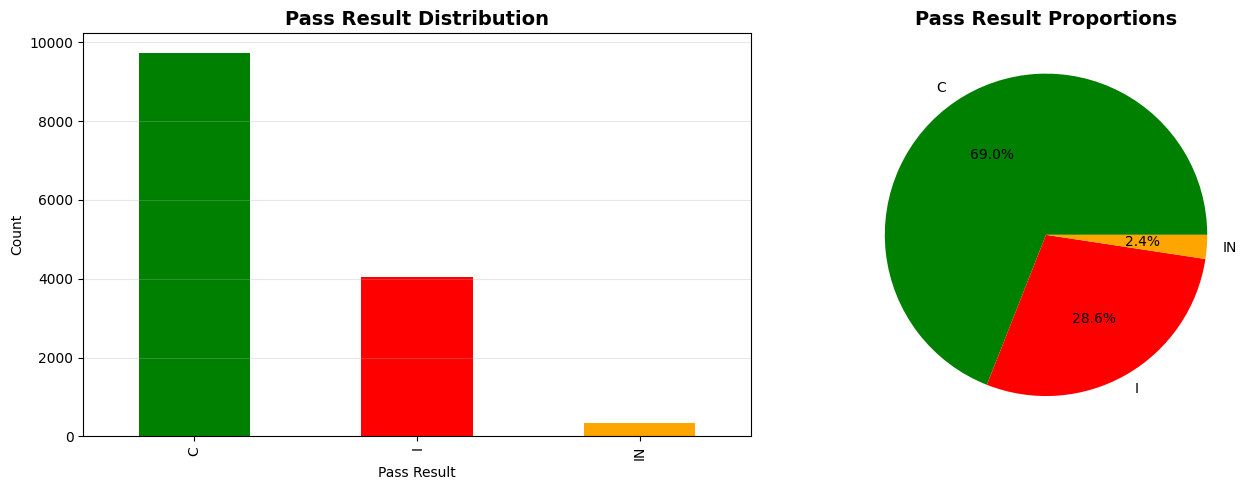

In [24]:
# Explore Target Variable
print("\\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

# Check pass_result distribution
if 'pass_result' in completion_df.columns:
    print("\\nPass Result Distribution:")
    result_counts = completion_df['pass_result'].value_counts()
    print(result_counts)
    print(f"\\nPercentages:")
    print(result_counts / len(completion_df) * 100)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Count plot
    result_counts.plot(kind='bar', ax=axes[0], color=['green', 'red', 'orange', 'blue', 'purple'])
    axes[0].set_title('Pass Result Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Pass Result')
    axes[0].set_ylabel('Count')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Pie chart
    axes[1].pie(result_counts.values, labels=result_counts.index, autopct='%1.1f%%',
                colors=['green', 'red', 'orange', 'blue', 'purple'])
    axes[1].set_title('Pass Result Proportions', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(MODELS_PATH / 'pass_result_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ pass_result column not found!")

removing features: qb_acceleration, dropback_distance, absolute_yardine_number, avg_defender_speed

In [25]:
# Feature Engineering for Completion Prediction
print("\\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Create binary completion target (simplify to Complete vs Not Complete)
completion_df['is_complete'] = (completion_df['pass_result'] == 'C').astype(int)

print(f"\\nBinary Target Distribution:")
print(completion_df['is_complete'].value_counts())
print(f"\\nCompletion Rate: {completion_df['is_complete'].mean():.2%}")

# Select features for modeling
numeric_features = [
    # QB features
    'qb_speed', 'qb_dist_to_sideline',
    # Target features
    'target_speed', 'target_acceleration', 'target_dist_to_ball_land',
    'receiver_separation', 'target_nearest_defender', 'qb_target_distance',
    # Defensive features
    'num_defenders', 'avg_defender_separation',
    'min_defender_separation', 'avg_defender_density',
    # Play context
    'down', 'yards_to_go', 'score_differential',
    'defenders_in_the_box', 'pass_length'
]

categorical_features = [
    'team_coverage_man_zone', 'team_coverage_type', 'dropback_type',
    'route_of_targeted_receiver', 'offense_formation', 'play_action'
]

# Filter to available features
numeric_features = [f for f in numeric_features if f in completion_df.columns]
categorical_features = [f for f in categorical_features if f in completion_df.columns]

print(f"\\nSelected Features:")
print(f"  Numeric: {len(numeric_features)}")
print(f"  Categorical: {len(categorical_features)}")
print(f"  Total: {len(numeric_features) + len(categorical_features)}")

\n================================================================================
FEATURE ENGINEERING
\nBinary Target Distribution:
is_complete
1    9738
0    4370
Name: count, dtype: int64
\nCompletion Rate: 69.02%
\nSelected Features:
  Numeric: 17
  Categorical: 6
  Total: 23


In [26]:
# Prepare Data for Modeling
print("\\n" + "="*80)
print("DATA PREPARATION")
print("="*80)

# Create feature matrix
X_numeric = completion_df[numeric_features].fillna(0)
X_categorical = completion_df[categorical_features].fillna('Unknown')

# Encode categorical features
label_encoders = {}
X_categorical_encoded = pd.DataFrame()

for col in categorical_features:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col].astype(str))
    label_encoders[col] = le

# Combine features
X = pd.concat([X_numeric, X_categorical_encoded], axis=1)
y = completion_df['is_complete']

print(f"\\nFeature Matrix Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
print(f"\\nFeature Names ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")


\n================================================================================
DATA PREPARATION
\nFeature Matrix Shape: (14108, 23)
Target Shape: (14108,)
\nFeature Names (23):
  1. qb_speed
  2. qb_dist_to_sideline
  3. target_speed
  4. target_acceleration
  5. target_dist_to_ball_land
  6. receiver_separation
  7. target_nearest_defender
  8. qb_target_distance
  9. num_defenders
  10. avg_defender_separation
  11. min_defender_separation
  12. avg_defender_density
  13. down
  14. yards_to_go
  15. score_differential
  16. defenders_in_the_box
  17. pass_length
  18. team_coverage_man_zone
  19. team_coverage_type
  20. dropback_type
  21. route_of_targeted_receiver
  22. offense_formation
  23. play_action


In [27]:
# Train-Test Split
print("\\n" + "="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\\nTrain Set: {X_train.shape[0]:,} samples")
print(f"  Complete: {y_train.sum():,} ({y_train.mean():.2%})")
print(f"  Incomplete: {(~y_train.astype(bool)).sum():,} ({(1-y_train.mean()):.2%})")

print(f"\\nTest Set: {X_test.shape[0]:,} samples")
print(f"  Complete: {y_test.sum():,} ({y_test.mean():.2%})")
print(f"  Incomplete: {(~y_test.astype(bool)).sum():,} ({(1-y_test.mean()):.2%})")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\\n✅ Features normalized")


\n================================================================================
TRAIN-TEST SPLIT
\nTrain Set: 11,286 samples
  Complete: 7,790 (69.02%)
  Incomplete: 3,496 (30.98%)
\nTest Set: 2,822 samples
  Complete: 1,948 (69.03%)
  Incomplete: 874 (30.97%)
\n✅ Features normalized


In [28]:
# Handle Class Imbalance with SMOTE (Optional)
print("\\n" + "="*80)
print("HANDLING CLASS IMBALANCE")
print("="*80)

# Check if classes are imbalanced
class_ratio = y_train.value_counts()[1] / y_train.value_counts()[0]
print(f"\\nClass Ratio (Complete/Incomplete): {class_ratio:.2f}")

if class_ratio < 0.8 or class_ratio > 1.2:
    print("\\n⚠️ Classes are imbalanced. Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"\\nBalanced Train Set: {X_train_balanced.shape[0]:,} samples")
    print(f"  Complete: {y_train_balanced.sum():,} ({y_train_balanced.mean():.2%})")
    print(f"  Incomplete: {(~y_train_balanced.astype(bool)).sum():,} ({(1-y_train_balanced.mean()):.2%})")
else:
    print("\\n✅ Classes are balanced. No SMOTE needed.")
    X_train_balanced = X_train_scaled
    y_train_balanced = y_train


\n================================================================================
HANDLING CLASS IMBALANCE
\nClass Ratio (Complete/Incomplete): 2.23
\n⚠️ Classes are imbalanced. Applying SMOTE...
\nBalanced Train Set: 15,580 samples
  Complete: 7,790 (50.00%)
  Incomplete: 7,790 (50.00%)


In [29]:
# Model Training - Multiple Models
print("\\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Train
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
    
    try:
        auc = roc_auc_score(y_test, y_pred_proba_test)
    except:
        auc = None
    
    results[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'y_pred': y_pred_test,
        'y_pred_proba': y_pred_proba_test
    }
    
    print(f"\\n📊 Results:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Precision:      {precision:.4f}")
    print(f"  Recall:         {recall:.4f}")
    print(f"  F1 Score:       {f1:.4f}")
    if auc:
        print(f"  AUC-ROC:        {auc:.4f}")


\n================================================================================
MODEL TRAINING
\n============================================================
Training Logistic Regression...
\n📊 Results:
  Train Accuracy: 0.6909
  Test Accuracy:  0.6914
  Precision:      0.8188
  Recall:         0.7100
  F1 Score:       0.7605
  AUC-ROC:        0.7282
\n============================================================
Training Random Forest...
\n📊 Results:
  Train Accuracy: 0.8311
  Test Accuracy:  0.7069
  Precision:      0.8075
  Recall:         0.7556
  F1 Score:       0.7807
  AUC-ROC:        0.7398
\n============================================================
Training Gradient Boosting...
\n📊 Results:
  Train Accuracy: 0.8054
  Test Accuracy:  0.7367
  Precision:      0.7870
  Recall:         0.8480
  F1 Score:       0.8164
  AUC-ROC:        0.7435
\n============================================================
Training XGBoost...
\n📊 Results:
  Train Accuracy: 0.8666
  Test Accuracy

In [30]:
# Model Comparison
print("\\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Acc': [r['train_acc'] for r in results.values()],
    'Test Acc': [r['test_acc'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1 Score': [r['f1'] for r in results.values()],
    'AUC-ROC': [r['auc'] if r['auc'] else 0 for r in results.values()]
})

print("\\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"\\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {results[best_model_name]['f1']:.4f}")


\n================================================================================
MODEL COMPARISON
\n               Model  Train Acc  Test Acc  Precision   Recall  F1 Score  AUC-ROC
Logistic Regression   0.690945  0.691354   0.818828 0.709959  0.760517 0.728214
      Random Forest   0.831118  0.706945   0.807460 0.755647  0.780695 0.739831
  Gradient Boosting   0.805423  0.736712   0.787041 0.848049  0.816407 0.743484
            XGBoost   0.866560  0.733522   0.777108 0.860883  0.816853 0.738629
\n🏆 Best Model: XGBoost
   F1 Score: 0.8169


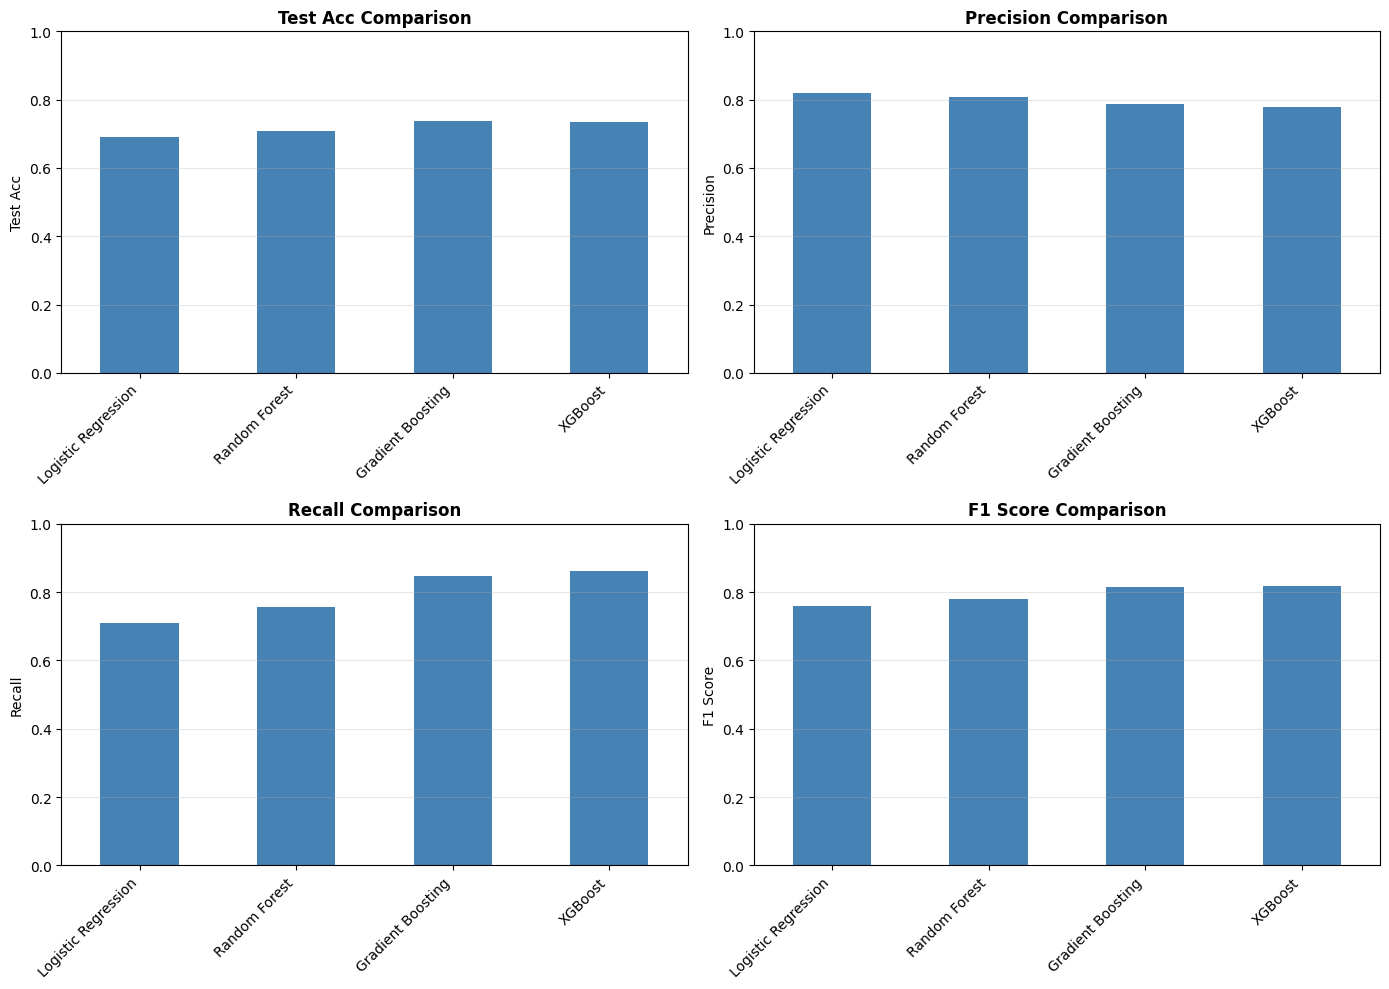

In [31]:
# Visualize Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Test Acc', 'Precision', 'Recall', 'F1 Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(MODELS_PATH / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

\n================================================================================
CONFUSION MATRIX - XGBoost


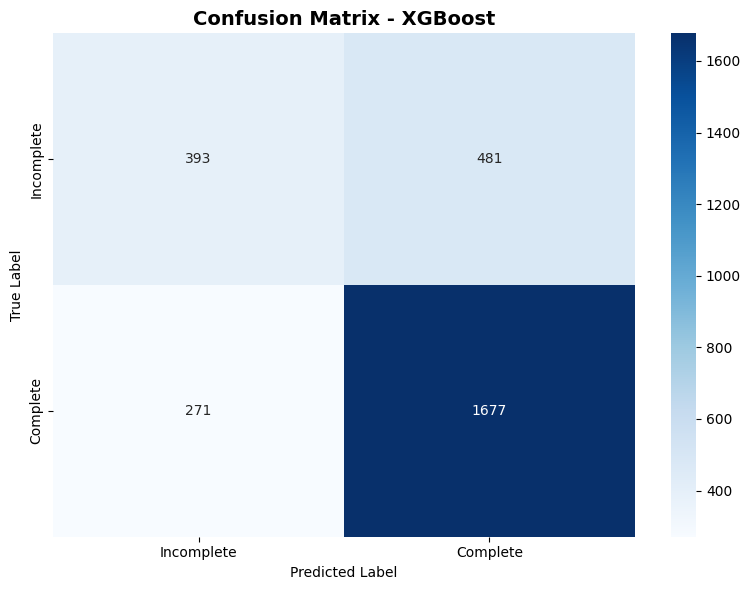

\nClassification Report:
              precision    recall  f1-score   support

  Incomplete       0.59      0.45      0.51       874
    Complete       0.78      0.86      0.82      1948

    accuracy                           0.73      2822
   macro avg       0.68      0.66      0.66      2822
weighted avg       0.72      0.73      0.72      2822



In [32]:
# Confusion Matrix for Best Model
print("\\n" + "="*80)
print(f"CONFUSION MATRIX - {best_model_name}")
print("="*80)

y_pred_best = results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Incomplete', 'Complete'],
            yticklabels=['Incomplete', 'Complete'])
ax.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(MODELS_PATH / f'confusion_matrix_{best_model_name.replace(" ", "_")}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Incomplete', 'Complete']))

\n================================================================================
ROC CURVE - XGBoost


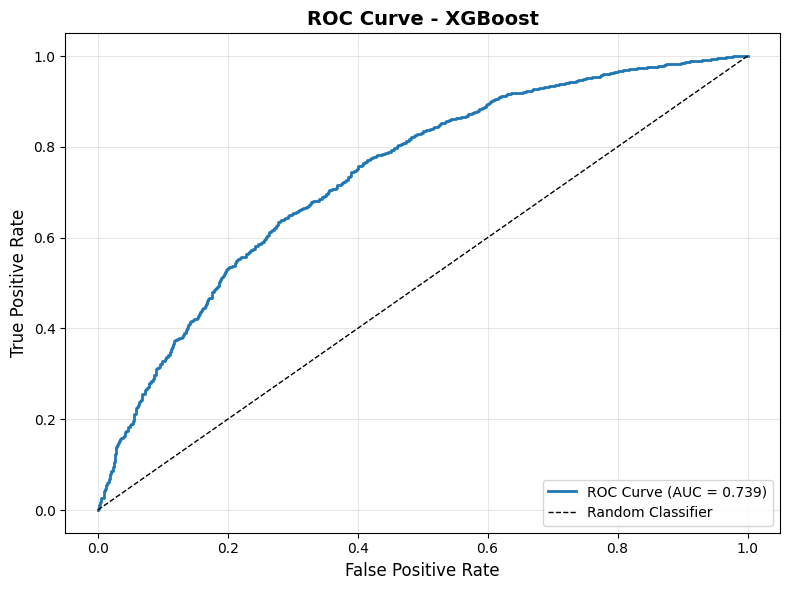

In [33]:
# ROC Curve for Best Model
if results[best_model_name]['auc']:
    print("\\n" + "="*80)
    print(f"ROC CURVE - {best_model_name}")
    print("="*80)
    
    y_pred_proba_best = results[best_model_name]['y_pred_proba']
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
    auc = results[best_model_name]['auc']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(MODELS_PATH / f'roc_curve_{best_model_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

\n================================================================================
FEATURE IMPORTANCE - XGBoost
\nTop 20 Most Important Features:
                   Feature  Importance
        team_coverage_type    0.122432
       receiver_separation    0.122020
      defenders_in_the_box    0.098311
                      down    0.087884
  target_dist_to_ball_land    0.060034
             num_defenders    0.056339
               pass_length    0.054398
route_of_targeted_receiver    0.053654
               yards_to_go    0.040772
         offense_formation    0.037750
        score_differential    0.036051
      avg_defender_density    0.032923
             dropback_type    0.029338
               play_action    0.027931
        qb_target_distance    0.024237
              target_speed    0.022388
       qb_dist_to_sideline    0.018430
       target_acceleration    0.017681
   min_defender_separation    0.017490
   avg_defender_separation    0.017294


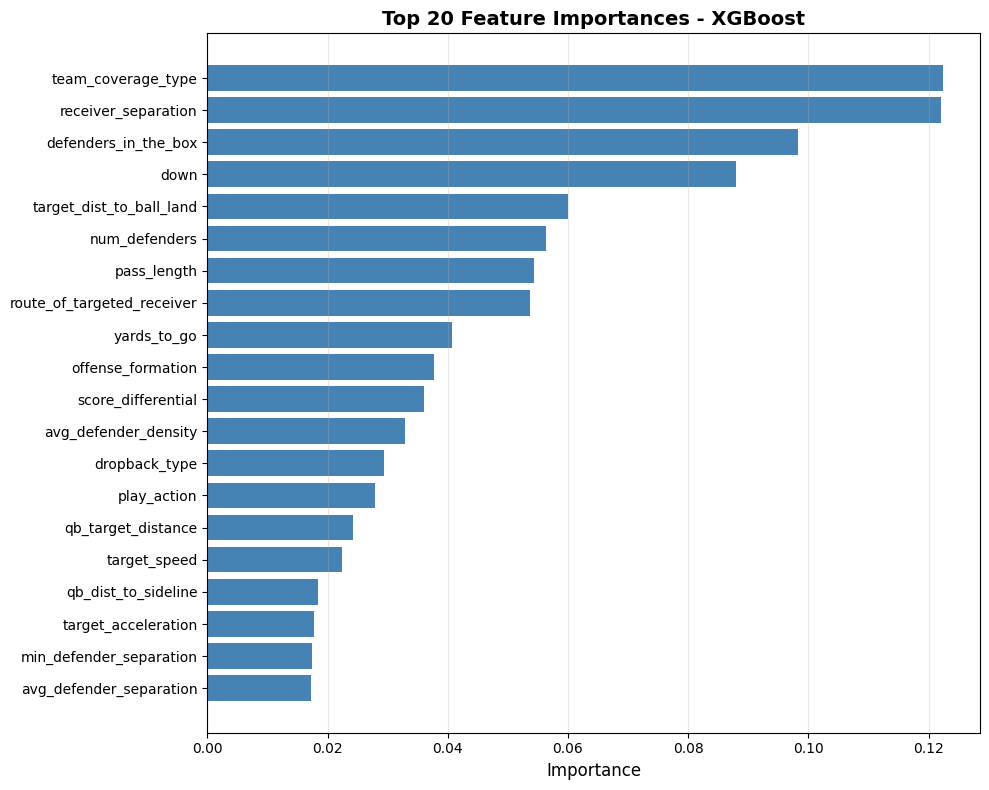

In [34]:
# Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print("\\n" + "="*80)
    print(f"FEATURE IMPORTANCE - {best_model_name}")
    print("="*80)
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\\nTop 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = feature_importance.head(20)
    ax.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title(f'Top 20 Feature Importances - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(MODELS_PATH / f'feature_importance_{best_model_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

In [35]:
# Save Best Model and Artifacts
print("\\n" + "="*80)
print("SAVING MODEL AND ARTIFACTS")
print("="*80)

# Save model
model_path = MODELS_PATH / f'completion_model_{best_model_name.replace(" ", "_")}.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\\n✅ Model saved: {model_path}")

# Save scaler
scaler_path = MODELS_PATH / 'completion_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved: {scaler_path}")

# Save label encoders
encoders_path = MODELS_PATH / 'completion_label_encoders.pkl'
with open(encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label encoders saved: {encoders_path}")

# Save feature names
features_path = MODELS_PATH / 'completion_features.pkl'
with open(features_path, 'wb') as f:
    pickle.dump({
        'numeric_features': numeric_features,
        'categorical_features': categorical_features,
        'all_features': list(X.columns)
    }, f)
print(f"✅ Feature names saved: {features_path}")

# Save results
results_path = MODELS_PATH / 'completion_model_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump({
        'comparison': comparison_df,
        'best_model_name': best_model_name,
        'results': {k: {kk: vv for kk, vv in v.items() if kk != 'model'} 
                   for k, v in results.items()}
    }, f)
print(f"✅ Results saved: {results_path}")

print("\\n" + "="*80)
print("✅ COMPLETION PREDICTION MODEL COMPLETE!")
print("="*80)
print(f"\\nBest Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test_acc']:.4f}")
print(f"F1 Score: {results[best_model_name]['f1']:.4f}")
print(f"AUC-ROC: {results[best_model_name]['auc']:.4f}")
print("\\n📁 All artifacts saved to:", MODELS_PATH)

\n================================================================================
SAVING MODEL AND ARTIFACTS
\n✅ Model saved: ..\models\completion_model_XGBoost.pkl
✅ Scaler saved: ..\models\completion_scaler.pkl
✅ Label encoders saved: ..\models\completion_label_encoders.pkl
✅ Feature names saved: ..\models\completion_features.pkl
✅ Results saved: ..\models\completion_model_results.pkl
\n================================================================================
✅ COMPLETION PREDICTION MODEL COMPLETE!
\nBest Model: XGBoost
Test Accuracy: 0.7335
F1 Score: 0.8169
AUC-ROC: 0.7386
\n📁 All artifacts saved to: ..\models


In [36]:
# Cross-Validation Analysis (Bonus)
print("\\n" + "="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\\n{name}:")
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                                 cv=cv, scoring='f1', n_jobs=-1)
    print(f"  CV F1 Scores: {cv_scores}")
    print(f"  Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\\n✅ Cross-validation complete")

\n================================================================================
CROSS-VALIDATION ANALYSIS
\nLogistic Regression:
  CV F1 Scores: [0.69150616 0.69184386 0.68424396 0.6951567  0.69894871]
  Mean F1: 0.6923 (+/- 0.0097)
\nRandom Forest:
  CV F1 Scores: [0.75908652 0.74846229 0.75327162 0.75372425 0.76144109]
  Mean F1: 0.7552 (+/- 0.0092)
\nGradient Boosting:
  CV F1 Scores: [0.81854714 0.80823199 0.82345754 0.82771306 0.82745826]
  Mean F1: 0.8211 (+/- 0.0145)
\nXGBoost:
  CV F1 Scores: [0.82399755 0.81495212 0.81537992 0.82481752 0.81915874]
  Mean F1: 0.8197 (+/- 0.0083)
\n✅ Cross-validation complete
